In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# Custom libraries/methods
from libs import split_data, evaluate_model

In [8]:
# Load dataset
df = pd.read_csv("data/preprocessed/main_ML_ready.csv")
df.head()

,Store,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Dept,Weekly_Sales,Store_Size,Year,Month,Day,Week,Store_Type_A,Store_Type_B,Store_Type_C
0,1,-0.963831,-1.72052,1.018422,0.078331,False,1,24924.50,0.238802,2010,2,5,5,True,False,False
1,1,-0.963831,-1.72052,1.018422,0.078331,False,2,50605.27,0.238802,2010,2,5,5,True,False,False
2,1,-0.963831,-1.72052,1.018422,0.078331,False,3,13740.12,0.238802,2010,2,5,5,True,False,False
3,1,-0.963831,-1.72052,1.018422,0.078331,False,4,39954.04,0.238802,2010,2,5,5,True,False,False
4,1,-0.963831,-1.72052,1.018422,0.078331,False,5,32229.38,0.238802,2010,2,5,5,True,False,False


### Split Data

In [9]:
# Split the data
X_train, X_test, y_train, y_test = split_data(df, target_column="Weekly_Sales")
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (336169, 15)
y_train shape:  (336169,)
X_test shape:  (84043, 15)
y_test shape:  (84043,)


# XGBoost model

### Train XGBoost model

In [10]:
# Initialize the XGBoost Regressor
xgb_model = XGBRegressor(
    objective='reg:squarederror',  # For regression tasks
    n_estimators=100,             # Number of trees
    learning_rate=0.1,            # Step size shrinkage
    max_depth=6,                  # Maximum depth of a tree
    random_state=42               # Reproducibility
)

# Train the model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [11]:
# Make predictions on the test set
y_pred = xgb_model.predict(X_test)
evaluate_model(y_test, y_pred)

Mean Absolute Error (MAE): 3838.66
Root Mean Squared Error (RMSE): 6875.99
R² Score: 0.91


### Hyperparameter Tuning

In [12]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],          # Number of trees
    'max_depth': [4, 6, 8],                  # Tree depth
    'learning_rate': [0.01, 0.1, 0.2],       # Learning rate
    'subsample': [0.8, 1.0],                 # Fraction of data per tree
    'colsample_bytree': [0.8, 1.0],          # Fraction of features per tree
    'min_child_weight': [1, 5, 10]           # Minimum leaf weight
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42, tree_method='gpu_hist'),
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score (Negative MAE):", grid_search.best_score_)

# Retrieve the best model
best_xgb_model = grid_search.best_estimator_

Fitting 3 folds for each of 324 candidates, totalling 972 fits


C:\Users\ishar\.virtualenvs\ML_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:48:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 8, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 1.0}
Best Cross-Validation Score (Negative MSE): -1728.906733443254


### Evaluate the Tuned Model

In [ ]:
# # As a backup of the best hyperparameter set
# best_xgb_model = XGBRegressor(
#     objective='reg:squarederror',
#     colsample_bytree=0.8,
#     n_estimators=300,     
#     learning_rate=0.2,  
#     max_depth=6,
#     random_state=42,
#     min_child_weight= 5,
#     subsample=1
# )

In [13]:
# Calculate evaluation metrics with best model
y_pred = best_xgb_model.predict(X_test)
evaluate_model(y_test, y_pred)

Mean Absolute Error (MAE): 1642.28
Root Mean Squared Error (RMSE): 3175.93
R² Score: 0.98


C:\Users\ishar\.virtualenvs\ML_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:48:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\ishar\.virtualenvs\ML_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:48:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the 

### Feature Importance Plot

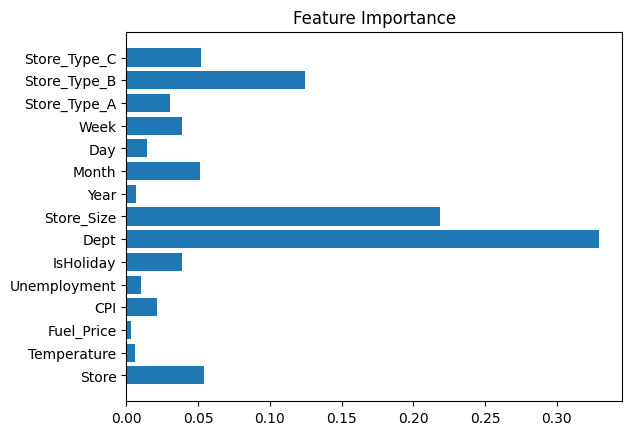

In [14]:
importances = best_xgb_model.feature_importances_
features = X_train.columns
plt.barh(features, importances)
plt.title('Feature Importance')
plt.show()